# Variants of gradient-based optimization

## Steps

1. Setting the scene
2. Stochastic Gradient Descent (SGD)
3. SGD with adaptive learning rate
4. SGD with momentum 
5. SGD with accumulated squared gradient: AdaGrad
6. SGD with accumulated squared gradient: RMSProp
7. SGD with accumulated squared gradient: ADAM
8. SGD with Newton’s method
9. SGD with the conjugate gradient method

## Setting the scene

During learning, we optimize the mean squared error $MSE$ of the models $m$ for the model parameters $\mathbf w$: 

$$MSE(\mathbf w,m,X,Y) =\frac{1}{N}\sum_{i=1}^{N}(y_i - m(\mathbf w, \mathbf  x_i))^2$$

In other words, we find $\arg\min_{\mathbf w} MSE(\mathbf w, m, X, Y)$.

We will reuse some functions defined in the notebook "Learn an XOR Neural Network using gradient-based optimization" including:
1. The mean squared error function `mse` (loss function).
2. The gradient of the mean squared error function `grad_mse` (gradient of the loss function).
3. The gradient descent function for the loss function `grad_desc_mse`.
4. The 3D surcace and contour plot function `plot3D`.

First we generate sample data points. The generator function is $y=20x_1 -3x_2$. We sample data at integer points $x_{i,1}\times x_{i,2} \in [1\ldots N]\times [1\ldots N], N=100$ and add a random error to $y_i$ that is normally distributed proportional to $\mathcal{N}(0,10)$. 

Below we plot the function.

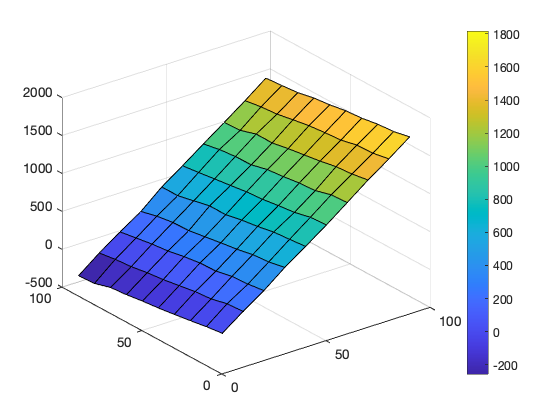

In [334]:
rng(1);
N=100; %N=1000;
XX=fliplr(fullfact([N N]));
a10 = 20;
a20 = -3;
X1 = XX(:,1);
X2 = XX(:,2);

f0 = @(x1,x2)(a10*x1 + a20*x2);
f = @(x1,x2,r)(a10*x1 + a20*x2 + r);
R = normrnd(0,10,1,N*N).';
Y = arrayfun(f,X1,X2,R);
[A,B] = meshgrid(1:N/10:N,1:N/10:N);
ff =@(x1,x2)(f(x1,x2,normrnd(0,10)));
plot3d(ff,A,B, true);

The model that we use throughout this notebook is a simple linear Neural Network model. It consists of one neuron connected to the input $\mathbf x$ and an identity, i.e., no effective, activation function. The neuron and the whole model $m_1$ implements $m_1(\mathbf w, \mathbf x) = \mathbf w^T \mathbf x$.

In [335]:
m1 = @(ws,x)(ws(1)*x(1) + ws(2)*x(2));
mse1 = @(ws)(mse(ws,m1,XX,Y));

As the Tensorflow default, we implement the Glorot uniform initializer for setting the initial weights $\mathbf w_0$.
It draws samples from a uniform random distribution within $[-\mathit{limit}, \mathit{limit}]$,
where $\mathit{limit} = \sqrt{\frac{6}{\mathit{in} + \mathit{out}}}$, and
where $\mathit{in}$ and $\mathit{out}$ is the number of input and output units, resp.

In [336]:
in = 2;
out = 1;
limit = sqrt(6 / (in + out));
ws0 = [rand*2*limit-limit;rand*2*limit-limit]


ws0 =

    1.3988
    0.6175




We assess the loss $MSE$ of $m_1$ for this initial weights setting.

In [337]:
mse1(ws0)


ans =

   8.7171e+05




The gradient of $MSE(\mathbf w)$ for any $\mathbf w$ is defiend as:

$$
\begin{aligned}
\nabla_{MSE}(\mathbf w) &= \left [ 
\frac{\partial MSS(\mathbf w)}{\partial w_1}, 
\frac{\partial MSE(\mathbf w)}{\partial w_2}
\right ]^T\\
&= \frac{1}{N}\left [ 
\frac{\partial \sum_{i=1}^{N}(y_i - m_1(\mathbf w,\mathbf x_i))^2}{\partial w_1}, 
\frac{\partial \sum_{i=1}^{N}(y_i - m_1(\mathbf w,\mathbf x_i))^2}{\partial w_2} 
\right ]^T \\
&= \frac{1}{N} \left [ 
\sum_{i=1}^{N}2(y_i- m_1(\mathbf w,\mathbf x_i))\frac{-\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_1},
\sum_{i=1}^{N}2(y_i- m_1(\mathbf w,\mathbf x_i))\frac{-\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_2}
\right ]^T \\
&= -\frac{2}{N} \left [ 
\sum_{i=1}^{N}(y_i- m_1(\mathbf w,\mathbf x_i))\frac{\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_1},
\sum_{i=1}^{N}(y_i- m_1(\mathbf w,\mathbf x_i))\frac{\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_2}
\right ]^T \\
\end{aligned}
$$

We can plug in the function $m_1$ and the first derivative of $m_1$ wrt. $w$ and $b$ resp.

$$
\begin{aligned}
\frac{\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_1} &=\frac{\partial \mathbf w^T\mathbf x_{i}}{\partial w_1} = \frac{\partial w_1 x_{i,1} + w_2 x_{i,2}}{\partial w_1}  =x_{i,1}\\
\frac{\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_2} &=\frac{\partial \mathbf w^T\mathbf x_{i}}{\partial w_2} = \frac{\partial w_1 x_{i,1} + w_2 x_{i,2}}{\partial w_2}  = x_{i,2}\\
\end{aligned}
$$

We have already defined the function $m_1$. Let's also define the functions of the first derivative of $m_1$ wrt. $w_1$ and $w_2$ resp. For the sake of generality, we keep $\mathbf w$ as a formal parameter `ws` even though it is actually not needed for  derivatives of this concrete model $m_1$. 

In [338]:
gradients1{1} = @(ws,x)(x(1));
gradients1{2} = @(ws,x)(x(2));

The gradient $\nabla_{MSE}(\mathbf w)$ has been defined using $m_1$ and the first derivative of $m_1$ wrt. $w_1$ and $w_2$, resp., as parameters.

The gradient descent function optimizes $\mathbf w$ by iterating over:

$$\mathbf w_{k+1}= \mathbf w_k - \varepsilon \nabla_{MSE}(\mathbf w_k)$$

staring with $\mathbf w_0$.

Below we apply the gradient descent function minimizing $MSE$ for the model $m_1$. We plot the $MSE$ for each step $k$ in the iteration as a function of the current parameter setting $\mathbf w_k$. We also marked the starting point $\mathbf w_0$ with a `+` and the (ideal) minimum $(20, -3)$ with a `*`.

Elapsed time is 0.195471 seconds.



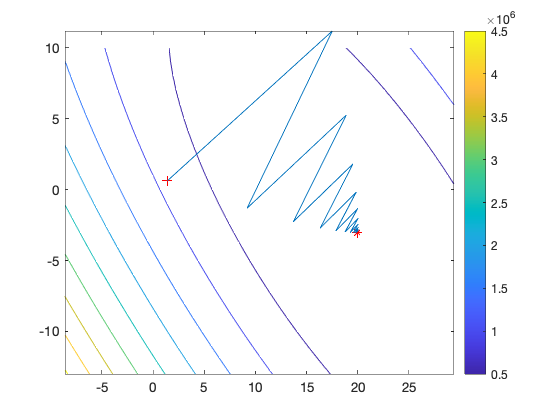

In [339]:
%% plot search space
f = @(a, b)(mse1([a,b]));
[A,B] = meshgrid(min(a10,ws0(1))-10:1:max(a10,ws0(1))+10,min(a20,ws0(2))-10:1:max(a20,ws0(2))+10);
plot3d(f, A, B, false) %3D contour
hold on
plot(a10,a20,'*r')
plot(ws0(1),ws0(2),'+r')

%% gradient descent
grad_loss = @(ws)(grad_mse(ws, m1, gradients1, XX, Y));
K = 20; %200;
learning_eps = 0.00015; %0.0000015; %0.000015;

tic;
[ws, history] = grad_desc_mse(K, ws0, learning_eps, mse1, grad_loss, true);
toc
hold off

The history plot shows the convergence of the algorithm. After ca. $k=15$ iterations, the loss $MSE$ is almost zero. 

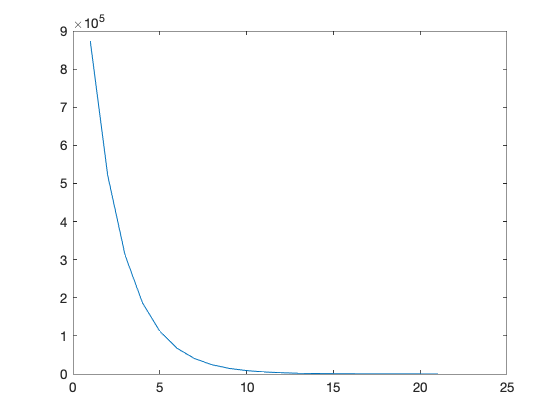

In [340]:
plot(1:length(history),history)

## Stochastic Gradient Descent (SGD)

SGD works like the gradient descent but computes the gradient based on a mini batch of size $m \ll N$. Therefore, our SGD implementation `stochastic_grad_desc_mse` generates in each iteration an array `randices`, i.e., random indices  making up the current mini batch sample of the whole data set. We resample this array in each iteration of the SGD algorithm.

We also define a corresponding `grad_mse2` function that computes the gradient only based on the mini batch data points. 

In [341]:
%%file stochastic_grad_desc_mse.m
function [ws, history] = stochastic_grad_desc_mse(K, ws, learning_eps, loss, grad_loss, N, verbose)
    batch_size = N*0.01;
    history(1) = loss(ws);
    for k = 1:K
        randices = randsample(1:N,batch_size,false);
        grad_ws = grad_loss(ws, randices);
        old_ws = ws;
        ws= old_ws - learning_eps * grad_ws;
        if verbose
            line([old_ws(1),ws(1)],[old_ws(2),ws(2)]);
        end
        history(k+1) = loss(ws);
    end
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV652/Public ML Notebooks/stochastic_grad_desc_mse.m'.


Elapsed time is 0.026219 seconds.



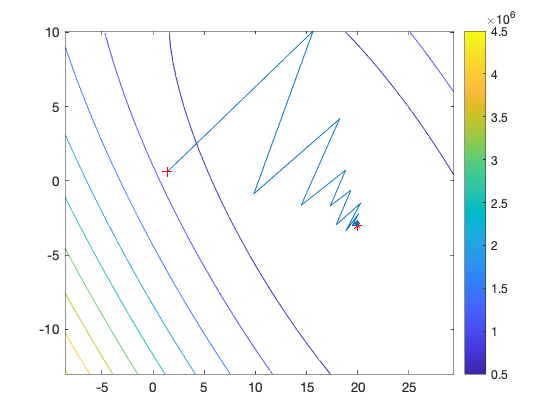

In [342]:
%% plot search space
plot3d(f, A, B, false) %3D contour
hold on
plot(a10,a20,'*r')
plot(ws0(1),ws0(2),'+r')

%% stochastic gradient descent
grad_loss2 = @(ws, randices)(grad_mse(ws, m1, gradients1, XX(randices,:),Y(randices)));
tic;
[ws, history] = stochastic_grad_desc_mse(K, ws0, learning_eps, mse1, grad_loss2, N*N, true);
toc

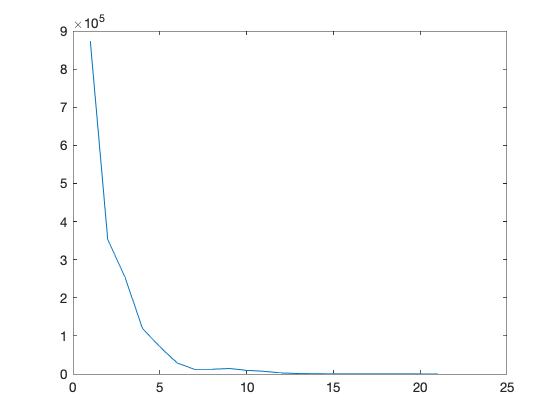

In [343]:
plot(1:length(history),history)

## SGD with adaptive learning rate

The learning rate $\varepsilon$ is adapted in each iteration, e.g., exponentially by $\varepsilon_{k+1} = (1-\alpha)\varepsilon_{k}$ with $\alpha$ a new hyper-parameter. 

In [345]:
%%file stochastic_adaptive_grad_desc_mse.m
function [ws, history] = stochastic_adaptive_grad_desc_mse(K, ws, learning_eps, loss, grad_loss, N, alpha, verbose)
    batch_size = N*0.01;
    history(1) = loss(ws);
    for k = 1:K
        randices = randsample(1:N,batch_size,false);
        grad_ws = grad_loss(ws, randices);
        old_ws = ws;
        ws= old_ws - learning_eps * grad_ws;
        learning_eps = (1-alpha) * learning_eps;
        if verbose
            line([old_ws(1),ws(1)],[old_ws(2),ws(2)]);
        end
        history(k+1) = loss(ws);
    end
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV652/Public ML Notebooks/stochastic_adaptive_grad_desc_mse.m'.


Elapsed time is 0.027499 seconds.



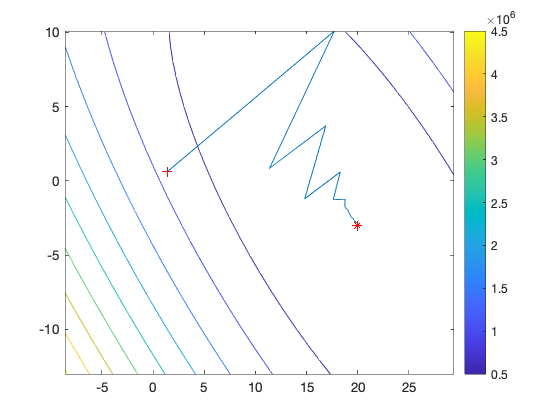

In [346]:
%% plot search space
plot3d(f, A, B, false) %3D contour
hold on
plot(a10,a20,'*r')
plot(ws0(1),ws0(2),'+r')

%% stochastic adaptive gradient descent
alpha = 0.03;
tic;
[ws, history] = stochastic_adaptive_grad_desc_mse(K, ws0, learning_eps, mse1, grad_loss2, N*N, alpha, true);
toc

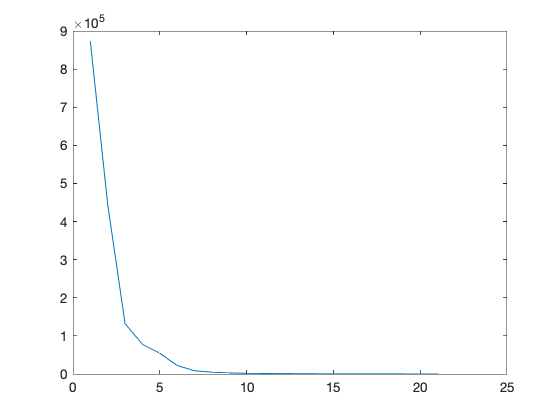

In [347]:
plot(1:length(history),history)

## SGD with momentum 

The gradient can be understood as a velocity at which we move towards the optimum. In this analogy, momentum $p$ is introduced as the velocity $v$ (gradient) times mass $m$, a new hyper-parameter of the algorithm. The velocity is set to the exponentially decaying moving average of past gradients. The initial velocity $v_0$ is the initial gradient. 

**OBS!** The velocity (earlier gradient vectors) and the current gradient vector point "uphill", i.e, into the inverse direction of the expected minimum. They should, hence, be **both** subtracted from the current parameters. 

In [366]:
%%file stochastic_momentum_grad_desc_mse.m
function [ws, history] = stochastic_momentum_grad_desc_mse(K, ws, learning_eps, loss, grad_loss, N, mass, verbose)
    batch_size = N*0.01;
    history(1) = loss(ws);
    v = 0;
    for k = 1:K
        randices = randsample(1:N,batch_size,false);
        grad_ws = grad_loss(ws, randices);
        v = (v+grad_ws)/2;
        old_ws = ws;
        ws= old_ws - mass * v - learning_eps * grad_ws;
        if verbose
            line([old_ws(1),ws(1)],[old_ws(2),ws(2)]);
        end
        history(k+1) = loss(ws);
    end
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV652/Public ML Notebooks/stochastic_momentum_grad_desc_mse.m'.


Elapsed time is 0.027203 seconds.



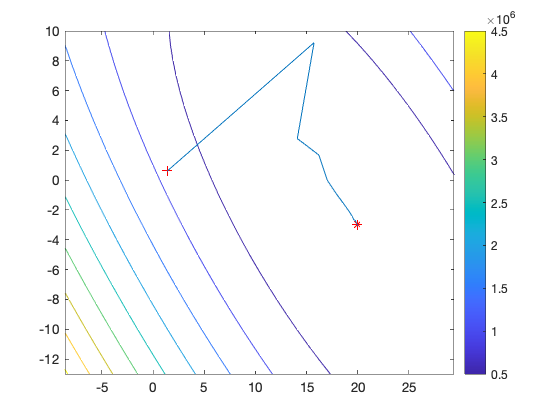

In [367]:
%% plot search space
plot3d(f, A, B, false) %3D contour
hold on
plot(a10,a20,'*r')
plot(ws0(1),ws0(2),'+r')

%% stochastic momentum gradient descent
mass = 1/2 * 0.00015;
learning_eps = 1/2 * 0.00015;
tic;
[ws, history] = stochastic_momentum_grad_desc_mse(K, ws0, learning_eps, mse1, grad_loss2, N*N, mass, true);
toc

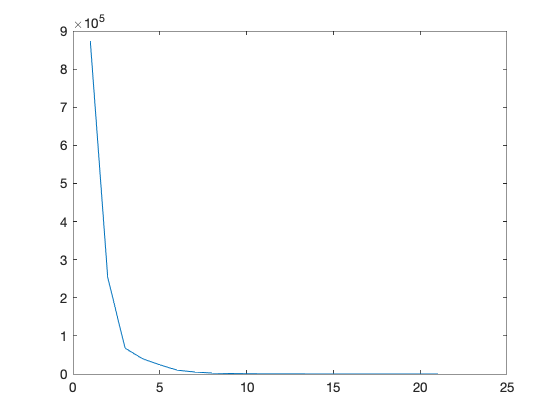

In [361]:
plot(1:length(history),history)

## SGD with accumulated squared gradient: AdaGrad

With AdaGrad, each parameter has its own learning rate.
This learning rate is always decreasing, but faster for the parameters with the larger gradients. The derease is quite fast, so we have to adapt the constant component $\varepsilon$ of the learning rate.

In [357]:
%%file ada_grad_mse.m
function [ws, history] = ada_grad_mse(K, ws, learning_eps, loss, grad_loss, N, verbose)
    batch_size = N*0.01;
    history(1) = loss(ws);
    r = zeros(length(ws),1);
    delta = 1e-10*ones(length(ws),1);
    for k = 1:K
        randices = randsample(1:N,batch_size,false);
        grad_ws = grad_loss(ws, randices);
        old_ws = ws;
        r = r + grad_ws .* grad_ws; 
        ws= old_ws - learning_eps/(delta+sqrt(r)) .* grad_ws;
        if verbose
            line([old_ws(1),ws(1)],[old_ws(2),ws(2)]);
        end
        history(k+1) = loss(ws);
    end
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV652/Public ML Notebooks/ada_grad_mse.m'.


Elapsed time is 0.027437 seconds.



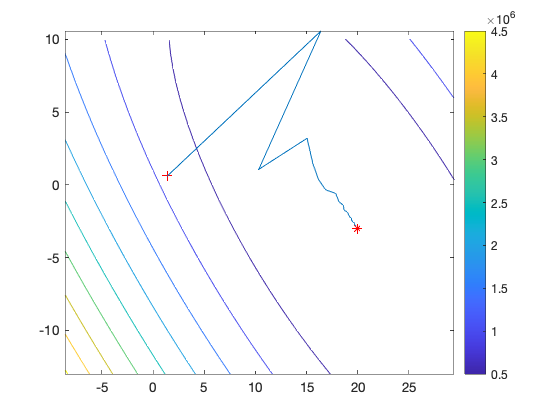

In [371]:
%% plot search space
plot3d(f, A, B, false) %3D contour
hold on
plot(a10,a20,'*r')
plot(ws0(1),ws0(2),'+r')

%% AdaGrad
learning_eps = 15;
tic;
[ws, history] = ada_grad_mse(K, ws0, learning_eps, mse1, grad_loss2, N*N, true);
toc

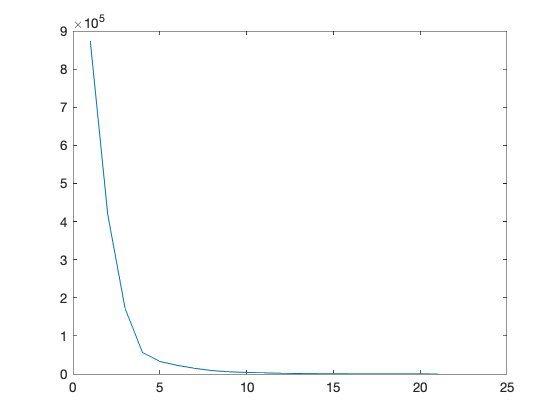

In [372]:
plot(1:length(history),history)

## SGD with accumulated squared gradient: RMSProp

RMSProp adds a hyper-parameter $\rho \in [0\ldots 1]$ to AdaGrad. It biases between the accumulated squared gradients $r$, i.e., the historic (squared) velocity, and the current squared gradient before deviding the learning rate by $\sqrt{r}$.

In [146]:
%%file rms_prob_mse.m
function [ws, history] = rms_prob_mse(K, ws, learning_eps, loss, grad_loss, N, rho, verbose)
    batch_size = N*0.01;
    history(1) = loss(ws);
    r = zeros(length(ws),1);
    delta = 1e-10*ones(length(ws),1);
    for k = 1:K
        randices = randsample(1:N,batch_size,false);
        grad_ws = grad_loss(ws, randices);
        old_ws = ws;
        r = rho*r + (1-rho) * grad_ws .* grad_ws; 
        ws= old_ws - learning_eps/(delta+sqrt(r)) .* grad_ws;
        if verbose
            line([old_ws(1),ws(1)],[old_ws(2),ws(2)]);
        end
        history(k+1) = loss(ws);
    end
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV652/Public ML Notebooks/rms_prob_mse.m'.


For RMSProb, it was hard to find good hyper-parameters just by trying out a few. Here the loss for different hyper-parameter settings of $\rho \in [0\ldots 1]$ and $\varepsilon \in [1\ldots 20]$. We finally chose the setting with the minimum loss after 20 iterations: $\varepsilon = 1, \rho=0.98$. Note, that we needed to increase the number of iterations to arrive at a the ideal parameters. So, for this simplistic setup, RMSProb did not speed up convergence.

![title](img/rms_prob_hyperparameters.png)

Elapsed time is 0.053136 seconds.



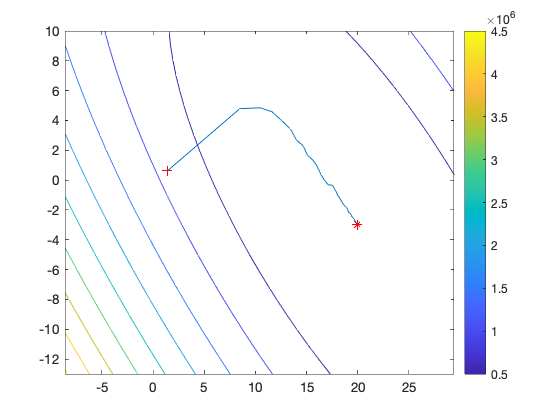

In [374]:
%% plot search space
plot3d(f, A, B, false) %3D contour
hold on
plot(a10,a20,'*r')
plot(ws0(1),ws0(2),'+r')

%% RMSProb; 
learning_eps = 1;
rho = 0.98;
K = 40; %!
tic;
[ws, history] = rms_prob_mse(K, ws0, learning_eps, mse1, grad_loss2, N*N, rho, true);
toc

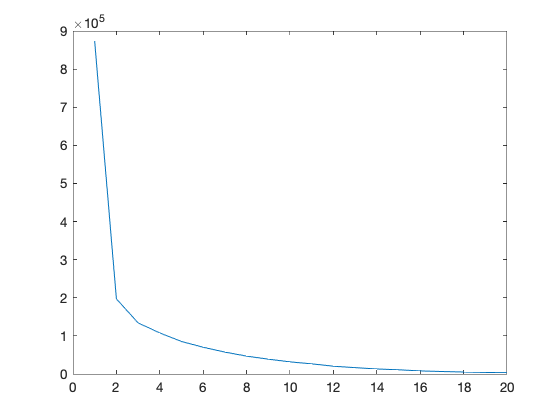

In [382]:
plot(1:20,history(1:20))

## SGD with accumulated squared gradient: ADAM

ADAM seems to be the current choice of many. However, it hasn't been trivial to choose the learning rate and the two hyper-parameters $\rho_1, \rho_2$. We even needed to increase the number of iterations to arrive at a the ideal parameters. So, for this simplistic setup, ADAM did not speed up convergence.

In [383]:
%%file adam_mse.m
function [ws, history] = adam_mse(K, ws, learning_eps, loss, grad_loss, N, rho1, rho2, verbose)
    batch_size = N*0.01;
    history(1) = loss(ws);
    s = zeros(length(ws),1);
    r = zeros(length(ws),1);
    t = 0;
    delta = 1e-10*ones(length(ws),1);
    for k = 1:K
        randices = randsample(1:N,batch_size,false);
        grad_ws = grad_loss(ws, randices);
        old_ws = ws;
        t = t +1;
        s = rho1*s + (1-rho1) * grad_ws; 
        r = rho2*r + (1-rho2) * grad_ws .* grad_ws; 
        s_hat = s/(1-rho1^t);
        r_hat = r/(1-rho2^t);
        ws= old_ws - (learning_eps*s_hat)/(delta+sqrt(r));
        if verbose
            line([old_ws(1),ws(1)],[old_ws(2),ws(2)]);
        end
        history(k+1) = loss(ws);
    end
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV652/Public ML Notebooks/adam_mse.m'.


Elapsed time is 0.502132 seconds.



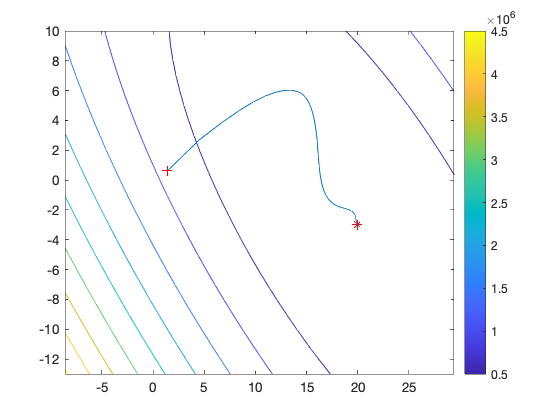

In [384]:
%% plot search space
plot3d(f, A, B, false) %3D contour
hold on
plot(a10,a20,'*r')
plot(ws0(1),ws0(2),'+r')

%% ADAM; 
learning_eps = 0.1; %0.001
rho1 = 0.9;
rho2 = 0.999;
K=400; %!!
tic;
[ws, history] = adam_mse(K, ws0, learning_eps, mse1, grad_loss2, N*N, rho1, rho2, true);
toc

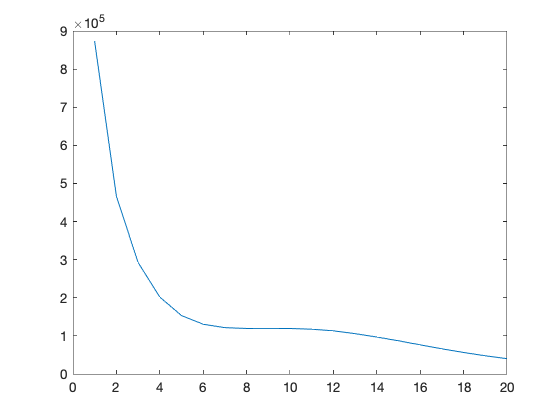

In [386]:
plot(1:20,history(1:20))

## SGD with Newton’s method 

It is obviously difficult to set the learning rate (and the other parameters) right. To help this, Newton's method (and other second order methods) involve the second order derivatives, e.g., the Hessian matrix $H_{MSE}$. Then they iterate:

$$
\mathbf w_{k+1} = \mathbf w_k - H_{MSE}(\mathbf w_k)^{-1} \nabla_{MSE}(\mathbf w_k) 
$$

where $H_{MSE}$ is the Hessian matrix of $MSE$. 

$H_{MSE}$ is defined as:
$$
\begin{aligned}
H_{MSE}(\mathbf w) &= 
\begin{bmatrix}
\frac{\partial^2 MSE(\mathbf w)}{\partial w_1^2} & \frac{\partial^2 MSE(\mathbf w)}{\partial w_1 \partial w_2} \\
\frac{\partial^2 MSE(\mathbf w)}{\partial w_2 \partial w_1} & \frac{\partial^2 MSE(\mathbf w)}{\partial w_2^2} 
\end{bmatrix}\\
&=
\frac{-2}{N}
\begin{bmatrix}
\frac{\partial (\sum_{i=1}^{N}(y_i- m_1(\mathbf w, \mathbf x_i)x_{i,1})}{\partial w_1} & 
\frac{\partial (\sum_{i=1}^{N}(y_i- m_1(\mathbf w, \mathbf x_i)x_{i,1})}{\partial w_2} \\
\frac{\partial (\sum_{i=1}^{N}(y_i- m_1(\mathbf w, \mathbf x_i)x_{i,2})}{\partial w_1} & 
\frac{\partial (\sum_{i=1}^{N}(y_i- m_1(\mathbf w, \mathbf x_i)x_{i,2})}{\partial w_2} \\
\end{bmatrix}\\
&=
\frac{2}{N}
\begin{bmatrix}
\sum_{i=1}^{N}x_{i,1}^2 & \sum_{i=1}^{N}x_{i,1}x_{i,2} \\
\sum_{i=1}^{N}x_{i,1}x_{i,2} & \sum_{i=1}^{N} x_{i,2}^2
\end{bmatrix}\\
\end{aligned}
$$

This approach generalizes easily to a stochastic version of Newtons method using only a sample of the training data of size $m \ll N$.

In [184]:
%%file hessian_mse.m
function H = hessian_mse(ws, X)
    N = length(X);
    M = length(ws);
    H = zeros(M);
    for r=1:M
        for c=1:M
            for i=1:N
                H(r,c) = H(r,c) + X(i,r)*X(i,c);
            end
        end
    end
    H = 2/N*H;
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV652/Public ML Notebooks/hessian_mse.m'.


In [197]:
grad2_loss = @(ws, randices)(hessian_mse(ws, XX(randices,:)));

In [198]:
%%file stochastic_newton_mse.m
function [ws, history] = stochastic_newton_mse(K, ws, loss, grad_loss, grad2_loss, N, verbose)
    batch_size = N*0.01;
    history(1) = loss(ws);
    for k = 1:K
        randices = randsample(1:N,batch_size,false);
        grad_ws = grad_loss(ws, randices);
        old_ws = ws;
        H = grad2_loss(ws, randices);
        ws= old_ws - inv(H) * grad_ws;
        if verbose
            line([old_ws(1),ws(1)],[old_ws(2),ws(2)]);
        end
        history(k+1) = loss(ws);
    end
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV652/Public ML Notebooks/stochastic_newton_mse.m'.


Elapsed time is 0.002432 seconds.



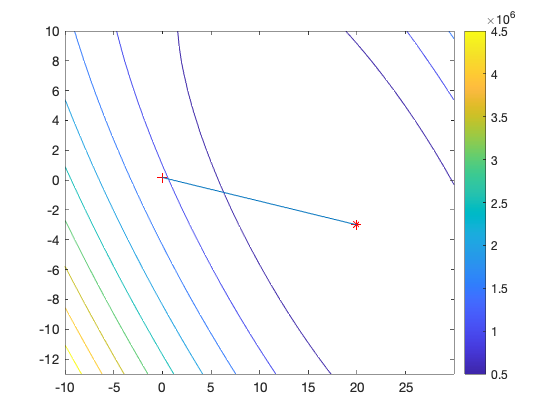

In [203]:
%% plot search space
plot3d(f, A, B, false) %3D contour
hold on
plot(a10,a20,'*r')
plot(ws0(1),ws0(2),'+r')

%% Newton's method; 
K=1; %!!!
tic;
[ws, history] = stochastic_newton_mse(K, ws0, mse1, grad_loss2, grad2_loss, N*N, true);
toc

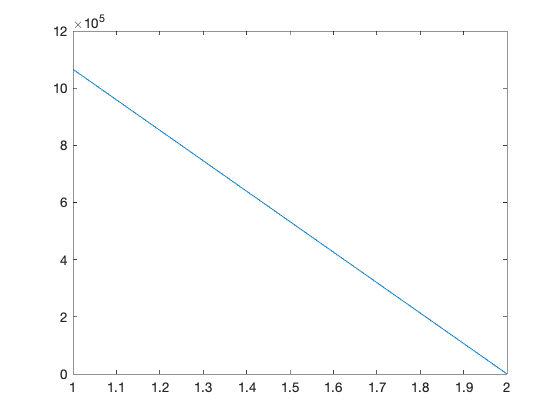

In [204]:
plot(1:length(history),history)

## SGD with the conjugate gradient method

The Hessian is quite large, with a size $O(n^2)$ for $n$ parameters, and needs to be updated in each iteration. The conjugate gradient method tries to avoid the explicite calculation of the Hessian. 

Part of the algorithm is a linear search along the (adjusted) gradient line for the optimum (lowest loss) point on this line. Therefore, we would like to use the mini batchg instead of the whole training data set. We define a stochastic loss function accordingly.  

In [209]:
mse2 = @(ws, randices)(mse(ws,m1,XX(randices,:),Y(randices)));

For the linear conjugate gradient descent, we search along the gradient line for the point to adjust the parameters to is the a step. For the non-linear conjugate gradient descent, we adjust the gradient line before this linear search based on the gradients' history. 

**OBS!** For the non-linear conjugate gradient descent, the gradient line adjustment (actually computing its scaling factor $\beta$) in iteration $k$ requires the gradient of iteration $k-1$. That is not available in the first iteration. Therefore, we need to do a linear (conjugate) gradient descent in the first iteration. 

In [390]:
%%file cg_mse.m
function [ws, history] = cg_mse(K, ws, loss, stochastic_loss, grad_loss, N, verbose)
    %initialization
    batch_size = N*0.01;
    history(1) = loss(ws);
    %we only need variables at t (var) and t-1 (var_old) 
    rho_old = zeros(length(ws),1);
    grad_ws_old = zeros(length(ws),1);
    
    for k = 1:K
        randices = randsample(1:N,batch_size,false);
        %Compute gradient
        grad_ws = grad_loss(ws, randices);
        if k==1
            %Linear cg, i.e., no search direction adjustment in the first round
            rho = - grad_ws;
        else
            %Compute Polak-Ribière
            beta = ((grad_ws - grad_ws_old)' * grad_ws) /(grad_ws_old' * grad_ws_old);
            %Compute search direction
            rho = - grad_ws + beta*rho_old;
        end
        %Naive line search for epsilon* = argmin stochastic_loss(ws+epsilon * rho)
        epsilon_star = 0.00001;
        minimum_star = stochastic_loss(ws+epsilon_star*rho,randices);
        for epsilon = 0.00001:0.0001:1
            minimum = stochastic_loss(ws+epsilon*rho,randices);
            if minimum < minimum_star
                epsilon_star = epsilon;
                minimum_star = minimum;
            end
        end
        %Remember parameters (for drawing the line of this step if verbose) 
        old_ws = ws;
        %Update the parameters
        ws= old_ws + epsilon_star * rho;
        %Remember the variables at t as the old variables at t-1 in the next iteration 
        rho_old = rho;
        grad_ws_old = grad_ws;
        %Draw the line 
        if verbose
            line([old_ws(1),ws(1)],[old_ws(2),ws(2)]);
        end
        history(k+1) = loss(ws);
    end
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV652/Public ML Notebooks/cg_mse.m'.


Elapsed time is 1.857940 seconds.



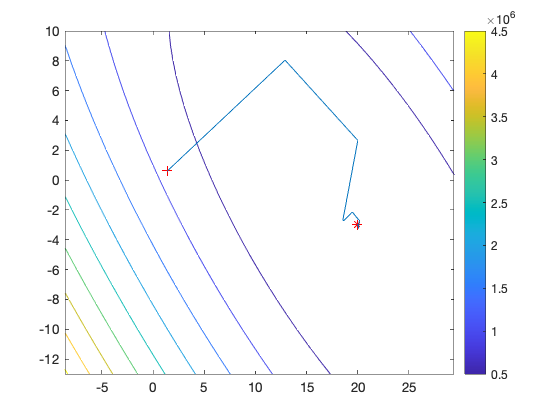

In [392]:
%% plot search space
plot3d(f, A, B, false) %3D contour
hold on
plot(a10,a20,'*r')
plot(ws0(1),ws0(2),'+r')

%% Newton's method; 
K=20;
tic;
[ws, history] = cg_mse(K, ws0, mse1, mse2, grad_loss2, N*N, true);
toc

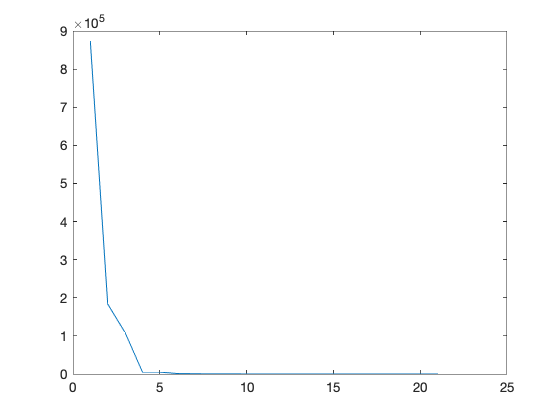

In [393]:
plot(1:length(history),history)